# Implementing a Progressive GAN

Mara Rehmer and Linus kleine Kruthaup

In [2]:
!pip install MTCNN

     |████████████████████████████████| 2.3MB 4.4MB/s 


In [177]:
import tensorflow as tf
import numpy as np
from PIL import Image 
import os
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt 
from keras.layers import Add, Conv2D, Layer, LeakyReLU, Reshape, Dense, AveragePooling2D, UpSampling2D, Flatten
from keras import backend, Sequential, Model, Input
from keras.initializers import RandomNormal
from keras.optimizers import Adam
import os 
import time
from matplotlib import pyplot
from skimage.transform import resize
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from keras.constraints import max_norm

%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 1 Preparing the data

The dataset we chose for our ProGAN to train on is CelebA (https://www.kaggle.com/jessicali9530/celeba-dataset). It consists of 202599 pictures of celebrity faces. The original dataset additionally holds information about different features of the face displayed in an image e.g. if the person is Bald or wears glasses. For our purposes we are only interested in the images though.

As a starting point we used the imgalignceleba version of the dataset which already cropped and alligned all of the imagest to the same dimensions. But this preprocessing is not sufficient for the task at hand. We additionally need to extract only the faces of each picture, since we are not interested in the backround. 

In order to extract the faces we used a pre-trained Neural Network called MTCNN to perform face detection on the images (https://github.com/ipazc/mtcnn). The models detect_faces function takes as input an array of pixels and returns a dictionary of coordinates for feature points like the nose, eyes and mouth, the confidence level of the network for the image at hand and a bounding box with x, y, width and height informations which can be used to cropp the face of the image.

Additionally we will only work with a subset of the original dataset for lower runtimes.  

In [5]:
# loads an image given a filename
def load_image(filename):
    with Image.open(filename) as image:
        # converts the image object into RGB, just in case
        image = image.convert('RGB')
    return image

In [ ]:
!unzip img_align_celeba.zip

In [ ]:
# crops all images of a given directory to the same size while also extracting
# all faces
def crop_faces(model, directory, n_images, crop_size = (128, 128)):
    faces = list()
    # iterating through file directory
    for filename in os.listdir(directory):
        # load image
        image = load_image(directory + filename)
        # extract all information needed for cropping the face 
        face_data = model.detect_faces(np.asarray(image))
        # do not do anything if mtcnn did not detect a face in a picture
        if face_data != []:
            # get the relevant coordinates and box dimensions
            x, y, width, height = face_data[0]['box']
            # extract the face and crop it to given size
            image_cropped = image.crop((x, y, x+width, y+height)).resize(crop_size)
            faces.append(np.asarray(image_cropped))
            # tracking the progress
            print(len(faces))
        # stop if specified amount of images are processed
        if len(faces) >= n_images:
            break
    return faces

# create MTCNN model
mtcnn = MTCNN()
# save the results of the crop_faces function as a compressed numpy file
np.savez_compressed('img_align_celeba_128.npz', crop_faces(mtcnn, '/content/img_align_celeba/', 100000))

Printing a few of the resulting images to see if everything functioned properly.

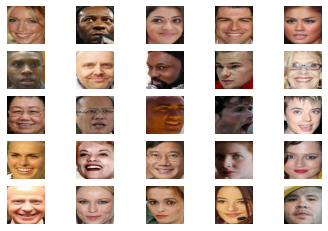

In [79]:
# plot some faces to make sure everything worked properly
def plot_faces(faces, n):
    for i in range(n*n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(faces[i])
    pyplot.show()

data = np.load('img_align_celeba_128.npz')
plot_faces(data['arr_0'],5)

## 2 Model

The general model architecture of a ProGAN features a discriminator and a generator similar to the architecture of a basic GAN. The core idea of a ProGAN however is to train the model on pictures of incrementaly increasing sizes. This is achieved by first training a model with a small origin resolution e.g. 4x4. Then we slowly fade in a new model with a higher resolution e.g. 8x8 with the help of a Custom Layer. 

### 2.1 Custom Layers

#### 2.1.1 Weighted Sum

This custom Layer is an extension to the Add merge Layer. It is used to combine the activations from two input layers e.g. two input paths in a discriminator or two output paths in a generator model. With its alpha variable the influence of either of the two paths can be controlled. In the training call we can then update the alpha of each model call that features the WeightedSum Layer dependent on the training step we are currently in. 

In [208]:
# custom layer that enables the addition and mixing of two seperate network paths
class WeightedSum(Add):
    # initial alpha should be 0 so that only input 1 has an influence
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')

    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        # ((1-a) * input1) + (a * input2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'alpha' : self.alpha
        })

#### 2.1.2 Pixel Normalization

In order to avoid a scenario for the training of the ProGAN where the magnitudes in the generator and discriminator get too large as a result of the competing loss functions the ProGAN uses a Normalization Layer that normalizes each pixel in the activation map to unit length. Pixel Normalization is only applied to the generator.

The formula for the normalization is defined as:

$ b_(x,y) = a_(x,y) / \sqrt{\frac{1}{N} \sum_{j=0}^{N-1}(a^j_{x,y})^2 + \epsilon}$, where ${\epsilon}$ is a small constant to deal with 0 means,
N the number of feature maps, $a_{x,y}$ the original and $b_{x,y}$ the normalized feature vector in pixel $(x,y)$, respectively.

In [162]:
class PixelNormalization(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs, **kwargs):
        # calculate square pixel values
        values = inputs ** 2.0
        # calculate the mean pixel values
        mean_values = backend.mean(values, axis=-1, keepdims=True)
        # ensure the mean is not zero
        mean_values += 1.0e-8
        # calculate the sqrt of the mean squared value (L2 norm)
        l2 = backend.sqrt(mean_values)
        # normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        return input_shape

#### 2.1.3 Minibatch Standard deviation

GANs often struggle to capture all the variation of a training dataset. Minibatch Standard devation tries to improve on this by computing feature statistics of a minibatches activations. More precisely it is implemented by first computing the mean of the standard deviation for each feature in each spatial location over the minibatch. The resulting constant feature map is then concatenated to the activation maps.

In [163]:
# mini-batch standard deviation layer
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs, **kwargs):
        # calculate the mean value for each pixel across channels
        mean = backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = backend.shape(inputs)
        output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = backend.concatenate([inputs, output], axis=-1)
        return combined

#### 2.1.4 Equalized Learning rate

Instead of carefully initializing the networks weights, the paper uses an equalized learning rate. This scales the weights at each layer with a constant.
This is performed during training in order to keep the networks weights at a similar scale during training.

The weights are scaled as follows:

$\hat{w_i} = w_i / c$, where $w_i$ are the weights and c is the per-layer normalization constant from He's initializer

The equalized learning rate can be implemented via a custom Conv2D layer.


In [209]:
# extending the Conv2D layer to implement equalized learning rate
class EqualizedConv2D(Conv2D):
    # initialize the scale as 1 for a neutral element division
    def __init__(self, *args, **kwargs):
        self.scale = 1.0
        super(EqualizedConv2D, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        fan_in = np.prod(input_shape[1:-1])
        self.scale = np.sqrt(2/fan_in)
        return super(EqualizedConv2D, self).build(input_shape)

    def call(self, inputs):
        outputs = backend.conv2d(inputs, self.kernel*self.scale, strides=self.strides, padding=self.padding, data_format=self.data_format, dilation_rate=self.dilation_rate)
        outputs = backend.bias_add( outputs, self.bias, data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

### 2.2 Loss

The paper uses Wasserstein loss but also mentions least squared error

In [210]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

### 2.3 Discriminator

In [271]:
# adding discrimnator models with increasing size to an existing discriminator
def add_discriminator_block(old_model, n_input_layers=3, filters=128):
    # weight initialization can be relaxed since we implemented equalized learning rate
    init = RandomNormal(stddev=0.8)
    # weight constraint
    const = max_norm(1)
    # get shape of existing model
    in_shape = list(old_model.input.shape)
    # define new input shape as double the size
    input_shape = (in_shape[-2] * 2, in_shape[-2] * 2, in_shape[-1])
    in_image = Input(shape=input_shape)
    # define new input processing layer
    d = EqualizedConv2D(filters, (1, 1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # define new block
    d = EqualizedConv2D(filters, (3, 3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = EqualizedConv2D(filters, (3, 3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
    block_new = d
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    # define straight-through model
    model1 = Model(in_image, d)
    # compile model
    model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=PARAMETERS.learning_rate,
                                                         beta_1=PARAMETERS.adam_beta1,
                                                         beta_2=PARAMETERS.adam_beta2,
                                                         epsilon=PARAMETERS.adam_epsilon))
    # downsample the new larger image
    downsample = AveragePooling2D()(in_image)
    # connect old input processing to downsampled new input
    block_old = old_model.layers[1](downsample)
    block_old = old_model.layers[2](block_old)
    # fade in output of old model input layer with new input
    d = WeightedSum()([block_old, block_new])
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    model2 = Model(in_image, d)
    # compile model
    model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=PARAMETERS.learning_rate,
                                                         beta_1=PARAMETERS.adam_beta1,
                                                         beta_2=PARAMETERS.adam_beta2,
                                                         epsilon=PARAMETERS.adam_epsilon))
    return [model1, model2]


# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4, 4, 3)):
    # weight initialization
    init = RandomNormal(stddev=0.8)
    # weight constraint
    const = max_norm(1)
    model_list = list()
    # base model input
    in_image = Input(shape=input_shape)
    # conv 1x1
    d = EqualizedConv2D(128, (1, 1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # conv 3x3 (output block)
    d = MinibatchStdev()(d)
    d = EqualizedConv2D(128, (3, 3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # conv 4x4
    d = EqualizedConv2D(128, (4, 4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # dense output layer
    d = Flatten()(d)
    out_class = Dense(1)(d)
    # define model
    model = Model(in_image, out_class)
    # compile model
    model.compile(loss=wasserstein_loss, optimizer=Adam(lr=PARAMETERS.learning_rate,
                                                        beta_1=PARAMETERS.adam_beta1,
                                                        beta_2=PARAMETERS.adam_beta2,
                                                        epsilon=PARAMETERS.adam_epsilon))
    # store model
    model_list.append([model, model])
    # create submodels
    for i in range(1, n_blocks):
        filters = 2**(10-i)
        if filters > 512:
            filters = 512
        if filters < 16:
            filters = 16
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        # create new model for next resolution
        models = add_discriminator_block(old_model)
        # store model
        model_list.append(models)
    return model_list

### 2.4 Generator

In [270]:
# add a generator block
def add_generator_block(old_model, filters=256):
    # weight initialization
    init = RandomNormal(stddev=0.8)
    # weight constraint
    const = max_norm(1)
    # get the end of the last block
    block_end = old_model.layers[-2].output
    # upsample, and define new block
    upsampling = UpSampling2D()(block_end)
    g = EqualizedConv2D(filters, (3, 3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    g = EqualizedConv2D(filters, (3, 3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    # add new output layer
    out_image = EqualizedConv2D(3, (1, 1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    # define model
    model1 = Model(old_model.input, out_image)
    # get the output layer from old model
    out_old = old_model.layers[-1]
    # connect the upsampling to the old output layer
    out_image2 = out_old(upsampling)
    # define new output image as the weighted sum of the old and new models
    merged = WeightedSum()([out_image2, out_image])
    model2 = Model(old_model.input, merged)

    return [model1, model2]


# define generator models
def define_generator(latent_dim, n_blocks, in_dim=4):
    # weight initialization
    init = RandomNormal(stddev=0.8)
    # weight constraint
    const = max_norm(1)
    model_list = list()
    # base model latent input
    in_latent = Input(shape=(latent_dim,))
    # linear scale up to activation maps
    g = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
    g = Reshape((in_dim, in_dim, 128))(g)
    # conv 4x4, input block
    # noinspection DuplicatedCode
    g = EqualizedConv2D(128, (3, 3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    # conv 3x3
    g = EqualizedConv2D(128, (3, 3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    # conv 1x1, output block
    out_image = EqualizedConv2D(3, (1, 1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    model = Model(in_latent, out_image)
    # store model
    model_list.append([model, model])
    # create submodels
    for i in range(1, n_blocks):
        filters = 2**(10-i)
        if filters > 512:
            filters = 512
        if filters < 16:
            filters = 16
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        # create new model for next resolution
        models = add_generator_block(old_model)
        # store model
        model_list.append(models)
    return model_list

### 2.5 Composite Model

In [229]:
# define composite models for training generators via discriminators
def define_composite(discriminators, generators):
    model_list = list()
    # create composite models
    for i in range(len(discriminators)):
        g_models, d_models = generators[i], discriminators[i]
        # straight-through model
        d_models[0].trainable = False
        model1 = Sequential()
        model1.add(g_models[0])
        model1.add(d_models[0])
        model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=PARAMETERS.learning_rate,
                                                             beta_1=PARAMETERS.adam_beta1,
                                                             beta_2=PARAMETERS.adam_beta2,
                                                             epsilon=PARAMETERS.adam_epsilon))
        # fade-in model
        d_models[1].trainable = False
        model2 = Sequential()
        model2.add(g_models[1])
        model2.add(d_models[1])
        model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=PARAMETERS.learning_rate,
                                                             beta_1=PARAMETERS.adam_beta1,
                                                             beta_2=PARAMETERS.adam_beta2,
                                                             epsilon=PARAMETERS.adam_epsilon))
        # store
        model_list.append([model1, model2])
    return model_list

## 3 Training

In [230]:
# scale images to preferred size
def scale_dataset(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

In [231]:
# load dataset
def load_real_samples(filename):
	# load dataset
	data = np.load(filename)
	# extract numpy array
	X = data['arr_0']
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [232]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return X, y

In [233]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [234]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = -np.ones((n_samples, 1))
    return X, y

In [235]:
def update_fadein(models, step, n_steps):
    # calculate current alpha (linear from 0 to 1)
    alpha = step / float(n_steps - 1)
    # update the alpha for each model
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                backend.set_value(layer.alpha, alpha)

In [236]:
# Return image to range [0,1]
def deprocess(x):
    x = np.clip(x, -1, 1)
    return (x + 1) / 2.0

In [237]:
def summarize_performance(status, g_model, latent_dim, n_samples=25):
    # devise name
    gen_shape = g_model.output_shape
    name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
    # generate images
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # normalize pixel values to the range [0,1]
    # X = (X - X.min()) / (X.max() - X.min())
    # plot real images
    square = int(np.sqrt(n_samples))
    for i in range(n_samples):
        pyplot.subplot(square, square, 1 + i)
        pyplot.axis('off')
        img = deprocess(X[i])
        pyplot.imshow(img)
    # save plot to file
    filename1 = 'plot_%s.jpg' % (name)
    pyplot.savefig(filename1)
    pyplot.close()
    print('>Saved: %s' % (filename1))

In [238]:
# train a generator and discriminator
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein=False):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# update alpha for all WeightedSum layers when fading in new blocks
		if fadein:
			update_fadein([g_model, d_model, gan_model], i, n_steps)
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, PARAMETERS.latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(PARAMETERS.latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))


# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
	# fit the baseline model
	g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
	# scale dataset to appropriate size
	gen_shape = g_normal.output_shape
	scaled_data = scale_dataset(dataset, gen_shape[1:])
	print('Scaled Data', scaled_data.shape)
	# train normal or straight-through models
	train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0])
	summarize_performance('tuned', g_normal, latent_dim)
	# process each level of growth
	for i in range(1, len(g_models)):
		# retrieve models for this level of growth
		[g_normal, g_fadein] = g_models[i]
		[d_normal, d_fadein] = d_models[i]
		[gan_normal, gan_fadein] = gan_models[i]
		# scale dataset to appropriate size
		gen_shape = g_normal.output_shape
		scaled_data = scale_dataset(dataset, gen_shape[1:])
		print('Scaled Data', scaled_data.shape)
		# train fade-in models for next level of growth
		train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True)
		summarize_performance('faded', g_fadein, latent_dim)
		# train normal or straight-through models
		train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i])
		summarize_performance('tuned', g_normal, latent_dim)

In [268]:
# defining all hyperparameters
class PARAMETERS(object):
    n_blocks = 5
    latent_dim = 128
    # Larger batch sizes for early training and smaller batch sizes for later 
    n_batch = [32, 16, 16, 8, 4]
    # Less epochs for early training because there is not much information too learn
    # opposite for later training
    n_epochs = [5, 8, 8, 10, 10]  
    # As given in the paper
    learning_rate = 0.001
    adam_beta1 = 0
    adam_beta2 = 0.99
    adam_epsilon = 10e-8

In [272]:
# define models
d_models = define_discriminator(PARAMETERS.n_blocks)
# define models
g_models = define_generator(PARAMETERS.latent_dim,PARAMETERS.n_blocks)
# define composite models
gan_models = define_composite(d_models, g_models)
# load image data
dataset = load_real_samples('img_align_celeba.npz')
print('Loaded', dataset.shape)
# train model
train(g_models, d_models, gan_models, dataset, PARAMETERS.latent_dim, PARAMETERS.n_epochs, PARAMETERS.n_epochs, PARAMETERS.n_batch)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
>20002, d1=-80348.641, d2=77057.641 g=-90777.141
>20003, d1=-82438.836, d2=71142.000 g=-121921.133
>20004, d1=-107149.953, d2=83542.938 g=-47522.688
>20005, d1=-147221.953, d2=109883.891 g=-148272.406
>20006, d1=-40594.227, d2=104718.953 g=-116793.344
>20007, d1=-330636.312, d2=82898.859 g=-118317.000
>20008, d1=-66072.375, d2=93406.367 g=-83910.922
>20009, d1=-124012.938, d2=146023.000 g=-90200.656
>20010, d1=-58956.055, d2=93037.531 g=-51518.898
>20011, d1=-88024.906, d2=79574.625 g=-60406.648
>20012, d1=-33907.133, d2=166235.453 g=-97159.094
>20013, d1=-101264.906, d2=191512.375 g=-100458.359
>20014, d1=-90382.977, d2=81924.109 g=-64295.633
>20015, d1=-107097.125, d2=116797.797 g=-105407.641
>20016, d1=-143078.188, d2=66014.547 g=-32904.688
>20017, d1=-76789.328, d2=63656.508 g=-69760.500
>20018, d1=-186774.531, d2=28635.207 g=-43470.816
>20019, d1=-342809.969, d2=157842.891 g=-80566.734
>20020, d1=-43794.691, d2=891